## Web Scraping Project

วัตถุประสงค์

1. เพื่อเรียนรู้การ Scraping เว็บไซต์

2. เพื่อค้นหาประเภทหนังสือที่ได้รับความนิยมมากที่สุดตามการจัดอันดับและบทวิจารณ์จากลูกค้า

3. เพื่อดูแนวโน้มราคาของหนังสือในแต่ละประเภทและเปรียบเทียบกับราคาเฉลี่ยของตลาด

4. เพื่อค้นหารูปแบบของหนังสือที่มีความต้องการสูงในท้องตลาด เพื่อให้ร้านมีความเข้าใจตลาดสำหรับการจัดสต็อกหนังสือใหม่ในคราวถัดไป

## ความสำคัญ

Book to Scrape เป็นเว็บไซต์ตัวอย่างที่ถูกสร้างขึ้นมาเพื่อใช้เป็นแหล่งข้อมูลในการฝึกฝนการสกัดข้อมูล (web scraping) โดยเฉพาะ เว็บไซต์นี้มีหนังสือหลากหลายประเภทที่มาพร้อมกับข้อมูลที่สำคัญ เช่น ชื่อหนังสือ, ราคา, ประเภทหนังสือ (genre), คะแนนความนิยม (rating), จำนวนรีวิว, และสถานะการมีสินค้า (in stock/out of stock) ข้อมูลเหล่านี้ถูกออกแบบมาให้เหมาะสำหรับผู้ที่ต้องการเรียนรู้และฝึกฝนการดึงข้อมูลจากเว็บไซต์

## ขั้นตอนที่ 1 การดึงข้อมูลจากเว็บ (Web Scraping)

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from urllib.parse import urljoin
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import matplotlib.pyplot as plt
import re
import csv
import seaborn as sns  # Ensure seaborn is imported
import matplotlib.pyplot as plt

In [2]:
# Base URL and initial page URL
base_url = 'https://books.toscrape.com/catalogue/category/books_1/'
start_url = urljoin(base_url, 'index.html')

# Function to scrape the genre from the book's detailed page
def scrape_book_genre(url):
    try:
        response = requests.get(url, timeout=10)
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract genre from the breadcrumb list
        breadcrumb_items = soup.select('ul.breadcrumb li')
        genre = 'Unknown Genre'
        if len(breadcrumb_items) > 2:
            genre_element = breadcrumb_items[2].a
            if genre_element:
                genre = genre_element.text.strip()

        return genre
    except requests.RequestException as e:
        print(f"Error scraping genre: {e}")
        return 'Unknown Genre'

# Function to scrape book details from a page
def scrape_books_from_page(url):
    try:
        response = requests.get(url, timeout=10)
        soup = BeautifulSoup(response.text, 'html.parser')

        books = []

        for book in soup.select('article.product_pod'):
            title = book.h3.a['title']
            price = book.select_one('p.price_color').text
            rating = book.p['class'][1]  # Extracts the rating
            availability_text = book.select_one('p.instock.availability').text.strip()

            # Extract the number of books remaining in stock using regex
            availability_match = re.search(r'(\d+) available', availability_text)
            if availability_match:
                availability = f"{availability_match.group(1)} books remaining"
            else:
                availability = "Out of stock" if 'Out of stock' in availability_text else "In stock"

            reviews = "N/A"  # Placeholder since reviews are not available
            book_page_url = urljoin(base_url, book.h3.a['href'])
            genre = scrape_book_genre(book_page_url)

            books.append({
                'Genre': genre,
                'Book Title': title,
                'Price': price,
                'Rating': rating,
                'Stock Status': availability,
                'Number of Reviews': reviews
            })

        return books
    except requests.RequestException as e:
        print(f"Error scraping books from page: {e}")
        return []

# Function to get the URL of the next page
def get_next_page(soup):
    next_button = soup.select_one('li.next a')
    if next_button:
        next_page_url = next_button['href']
        return urljoin(base_url, next_page_url)
    return None

# Function to scrape a single page and return the book details
def scrape_page(url):
    print(f'Scraping {url}')
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        books = scrape_books_from_page(url)
        return books, get_next_page(soup)
    except requests.RequestException as e:
        print(f'Error: {e}')
        return [], None

# Scrape all pages with concurrent requests
def scrape_all_pages(start_url):
    all_books = []
    current_url = start_url
    pages_to_scrape = [current_url]

    while pages_to_scrape:
        with ThreadPoolExecutor(max_workers=5) as executor:
            futures = [executor.submit(scrape_page, url) for url in pages_to_scrape]
            pages_to_scrape = []

            for future in as_completed(futures):
                try:
                    books, next_page_url = future.result()
                    all_books.extend(books)
                    if next_page_url:
                        pages_to_scrape.append(next_page_url)
                except Exception as e:
                    print(f'Error: {e}')

        time.sleep(1)  # Respectful delay to avoid overwhelming the server

    return all_books

# Start scraping
all_books = scrape_all_pages(start_url)

# Convert to pandas DataFrame
df = pd.DataFrame(all_books)

# Save DataFrame to CSV file
csv_file = 'Allbook.csv'
df.to_csv(csv_file, index=False, encoding='utf-8')

print(f'Data has been saved to {csv_file}')


Scraping https://books.toscrape.com/catalogue/category/books_1/index.html
Error: HTTPSConnectionPool(host='books.toscrape.com', port=443): Max retries exceeded with url: /catalogue/category/books_1/index.html (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1002)')))
Data has been saved to Allbook.csv


In [17]:
# Base URL of the Books to Scrape website
base_url = 'https://books.toscrape.com/catalogue/page-{}.html'

# Open a CSV file to write the data
with open('books_data.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Book Name', 'Remaining Stock'])

    # Initialize page number
    page_number = 1
    
    while True:
        # Construct the URL for the current page
        url = base_url.format(page_number)
        print(f"Scraping page {page_number}...")
        
        try:
            # Send a request to the page with a timeout
            response = requests.get(url, timeout=10)  # 10 seconds timeout
            response.raise_for_status()  # Raise an HTTPError for bad responses
        except requests.RequestException as e:
            print(f"Error occurred: {e}. Stopping.")
            break
        
        html_content = response.content
        soup = BeautifulSoup(html_content, 'html.parser')
        
        # Find all the books on the page
        books = soup.find_all('article', class_='product_pod')
        
        if not books:
            print("No more books found. Exiting.")
            break
        
        # Iterate over each book to get the title and availability
        for book in books:
            # Get the book title
            book_name = book.h3.a['title']
            
            # Navigate to the product page for more details
            product_link = book.find('a')['href']
            product_url = f"https://books.toscrape.com/catalogue/{product_link}"
            
            try:
                # Fetch the product page with a timeout
                product_response = requests.get(product_url, timeout=10)  # 10 seconds timeout
                product_response.raise_for_status()  # Raise an HTTPError for bad responses
            except requests.RequestException as e:
                print(f"Error occurred while fetching product page: {e}. Skipping.")
                continue
            
            product_soup = BeautifulSoup(product_response.content, 'html.parser')
            
            # Extract the stock information from the product page
            stock_info_tag = product_soup.find('p', class_='instock availability')
            stock_info = stock_info_tag.text.strip() if stock_info_tag else "Unknown"
            
            # Extract the number of available books if mentioned
            if '(' in stock_info:
                remaining_stock = stock_info.split('(')[-1].split(' ')[0]
            else:
                remaining_stock = "Unknown"
            
            # Write the data into the CSV file
            writer.writerow([book_name, remaining_stock])
        
        # Move to the next page
        page_number += 1
        
        # Add a delay to avoid overwhelming the server
        time.sleep(2)  # 2 seconds delay

print("Data has been saved to 'books_data.csv'")


Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...
Scraping page 11...
Scraping page 12...
Scraping page 13...
Scraping page 14...
Scraping page 15...
Scraping page 16...
Scraping page 17...
Scraping page 18...
Scraping page 19...
Scraping page 20...
Scraping page 21...
Scraping page 22...
Scraping page 23...
Scraping page 24...
Scraping page 25...
Scraping page 26...
Scraping page 27...
Scraping page 28...
Scraping page 29...
Scraping page 30...
Scraping page 31...
Scraping page 32...
Scraping page 33...
Scraping page 34...
Scraping page 35...
Scraping page 36...
Scraping page 37...
Scraping page 38...
Scraping page 39...
Scraping page 40...
Scraping page 41...
Scraping page 42...
Scraping page 43...
Scraping page 44...
Scraping page 45...
Scraping page 46...
Scraping page 47...
Scraping page 48...
Scraping page 49...
Scraping page 50...
Scraping 

# ขั้นตอนที่ 2 การทําความสะอาดและเตรียมข้อมูล (Data Cleaning and Preparation)

In [3]:
# Load the CSV file
csv_file = 'Web_Scraping_Project.csv'
df = pd.read_csv(csv_file)

# Clean the 'Price' column by removing the unwanted character (Â)
df['Price'] = df['Price'].str.replace('Â', '', regex=False)

# Map words to numbers in the 'Rating' column
rating_map = {
    'One': 1,
    'Two': 2,
    'Three': 3,
    'Four': 4,
    'Five': 5
}
df['Rating'] = df['Rating'].map(rating_map)

# Fill missing or empty 'Number of Reviews' with "N/A"
df['Number of Reviews'] = df['Number of Reviews'].fillna('N/A')

# Save the cleaned data back to the CSV file
df.to_csv(csv_file, index=False, encoding='utf-8')

print(f'Cleaned data and filled missing reviews have been saved to {csv_file}')


Cleaned data and filled missing reviews have been saved to Web_Scraping_Project.csv


### หาหนังสือที่ชื่อซ้ำกัน


In [2]:
def find_duplicates(file_path):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Check for duplicate 'Book Title'
    duplicates = df[df.duplicated(subset='Book Title', keep=False)]
    
    if not duplicates.empty:
        print("Duplicate Books Found:")
        print(duplicates)
    else:
        print("No duplicate books found.")

# Example usage
find_duplicates('Bookinfo.csv')


Duplicate Books Found:
       Genre              Book Title    Price Rating Stock Status  \
236  Fantasy  The Star-Touched Queen  Â£46.02   Five     In stock   
358  Fantasy  The Star-Touched Queen  Â£32.30   Five     In stock   

     Number of Reviews  
236                NaN  
358                NaN  


## ขั้นตอนที่ 3 การวิเคราะห์ข้อมูล (Data Analysis)

#### การคํานวณราคาเฉลี่ยและการจัดอันดับตามประเภท 

In [3]:
# Load the CSV file
csv_file = 'Web_Scraping_Project.csv'
df = pd.read_csv(csv_file)

# Clean and convert 'Price' column
df['Price'] = df['Price'].replace('[£]', '', regex=True).astype(float)

# Clean and convert 'Rating' column
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

# Group by 'Genre' and calculate the average price and rating for each category
genre_analysis = df.groupby('Genre').agg({
    'Price': 'mean',
    'Rating': 'mean'
}).reset_index()

# Rename columns for clarity
genre_analysis.columns = ['Genre', 'Average Price', 'Average Rating']

# Sort by 'Average Rating' in descending order (highest rating first)
genre_analysis = genre_analysis.sort_values('Average Rating', ascending=False)

# Display the results
print("Genre-wise Analysis (sorted by Average Rating):")
print(genre_analysis)


Genre-wise Analysis (sorted by Average Rating):
                 Genre  Average Price  Average Rating
15             Erotica      19.190000        5.000000
2        Adult Fiction      15.360000        5.000000
29              Novels      54.810000        5.000000
9    Christian Fiction      34.385000        4.166667
19              Health      51.452500        3.750000
3                  Art      38.520000        3.625000
33              Poetry      35.974211        3.526316
24               Humor      33.501000        3.400000
43        Spirituality      35.098333        3.333333
49         Young Adult      35.449074        3.296296
21  Historical Fiction      33.644231        3.230769
17             Fiction      36.066615        3.184615
27           New Adult      46.383333        3.166667
25               Music      35.636923        3.153846
36            Religion      32.567143        3.142857
48      Womens Fiction      36.791176        3.117647
16             Fantasy      39.593

### การระบุแนวโน้มราคาในแต่ละประเภท

In [6]:
# Load the CSV file with the correct encoding
csv_file = 'Web_Scraping_Project.csv'
df = pd.read_csv(csv_file, encoding='utf-8-sig')

# Remove the '£' symbol from the 'Price' column and convert it to numeric
df['Price'] = df['Price'].replace('£', '', regex=True).astype(float)

# Group by 'Genre' and calculate the average price for each category
average_price_by_genre = df.groupby('Genre')['Price'].mean().reset_index()

# Sort the genres by average price in descending order
average_price_by_genre = average_price_by_genre.sort_values(by='Price', ascending=False)

# Display all genres sorted by average price
print(average_price_by_genre)

                 Genre      Price
45            Suspense  58.330000
29              Novels  54.810000
34            Politics  53.613333
19              Health  51.452500
27           New Adult  46.383333
8            Christian  42.496667
44    Sports and Games  41.166000
40           Self Help  40.620000
47              Travel  39.794545
16             Fantasy  39.593958
3                  Art  38.520000
31           Parenting  37.350000
22             History  37.295000
4        Autobiography  37.053333
48      Womens Fiction  36.791176
13            Cultural  36.580000
10            Classics  36.545263
11        Contemporary  36.200000
17             Fiction  36.066615
33              Poetry  35.974211
23              Horror  35.949412
42       Short Stories  35.880000
1        Add a comment  35.796418
25               Music  35.636923
49         Young Adult  35.449074
43        Spirituality  35.098333
41      Sequential Art  34.572267
14             Default  34.392697
9    Christian

### การวิเคราะห์รูปแบบความพร้อมของสินค้า

In [4]:
# Load the CSV file
csv_file = 'Web_Scraping_Project.csv'
df = pd.read_csv(csv_file)

# Clean and convert 'Price' column
df['Price'] = df['Price'].replace('[£]', '', regex=True).astype(float)

# Check and clean 'Stock Status' and 'Remaining Stock'
df['Stock Status'] = df['Stock Status'].str.strip()
df['Remaining Stock'] = pd.to_numeric(df['Remaining Stock'], errors='coerce')

# Analyze stock status by genre
genre_stock_analysis = df.groupby('Genre').agg({
    'Remaining Stock': ['mean', 'sum', 'count'],
    'Stock Status': lambda x: (x.str.lower() == 'out of stock').sum()
}).reset_index()

# Rename columns for clarity
genre_stock_analysis.columns = ['Genre', 'Average Remaining Stock', 'Total Remaining Stock', 'Number of Books', 'Out of Stock Count']

# Sort by 'Average Remaining Stock' in descending order (most stock first)
genre_stock_analysis = genre_stock_analysis.sort_values('Average Remaining Stock', ascending=False)

# Print the results for all genres
print("Stock analysis by Genre (sorted by Average Remaining Stock from high to low):")
print(genre_stock_analysis.to_string(index=False))

Stock analysis by Genre (sorted by Average Remaining Stock from high to low):
             Genre  Average Remaining Stock  Total Remaining Stock  Number of Books  Out of Stock Count
          Cultural                15.000000                   15.0                1                   0
             Crime                15.000000                   15.0                1                   0
           Erotica                15.000000                   15.0                1                   0
          Politics                15.000000                   45.0                3                   0
            Poetry                12.368421                  235.0               19                   0
         Christian                12.333333                   37.0                3                   0
            Health                12.250000                   49.0                4                   0
         Self Help                11.800000                   59.0                5       

## ขั้นตอนที่ 4 การสร้างภาพแสดงข้อมูล (Visualization)

### กราฟดูความสัมพันธ์ โดยใช้กราฟ bar plot ดูราคาเฉลี่ยและการจัดอันดับตามประเภท 

C:\Users\orawanya Eve\AppData\Local\Temp\ipykernel_17888\1470535757.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Average Price', y='Genre', data=genre_analysis, palette='viridis')
C:\Users\orawanya Eve\AppData\Local\Temp\ipykernel_17888\1470535757.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Average Rating', y='Genre', data=genre_analysis, palette='magma')


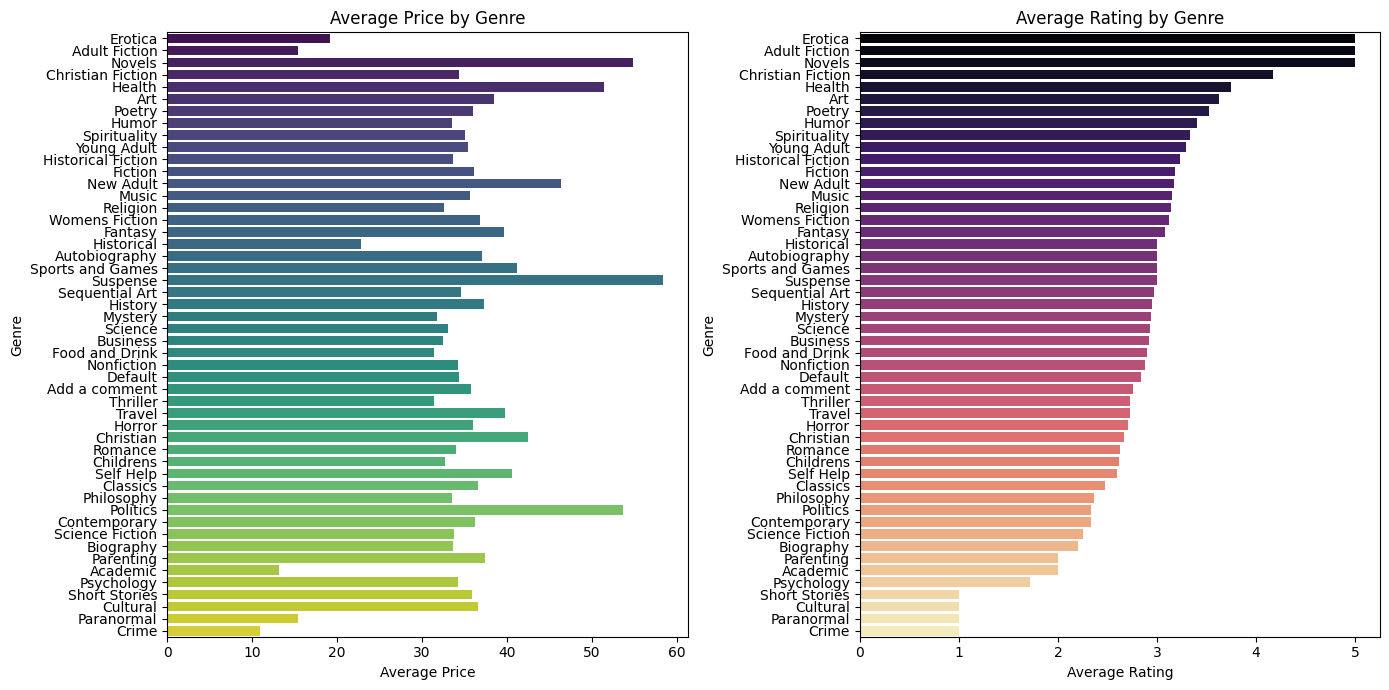

In [57]:
# Load the CSV file
csv_file = 'Web_Scraping_Project.csv'
df = pd.read_csv(csv_file)

# Clean and convert 'Price' column
df['Price'] = df['Price'].replace('[£]', '', regex=True).astype(float)

# Clean and convert 'Rating' column
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')

# Group by 'Genre' and calculate the average price and rating for each category
genre_analysis = df.groupby('Genre').agg({
    'Price': 'mean',
    'Rating': 'mean'
}).reset_index()

# Rename columns for clarity
genre_analysis.columns = ['Genre', 'Average Price', 'Average Rating']

# Sort by 'Average Rating' in descending order (highest rating first)
genre_analysis = genre_analysis.sort_values('Average Rating', ascending=False)

# Plot
plt.figure(figsize=(14, 7))

# Plot average price
plt.subplot(1, 2, 1)
sns.barplot(x='Average Price', y='Genre', data=genre_analysis, palette='viridis')
plt.title('Average Price by Genre')

# Plot average rating
plt.subplot(1, 2, 2)
sns.barplot(x='Average Rating', y='Genre', data=genre_analysis, palette='magma')
plt.title('Average Rating by Genre')

plt.tight_layout()
plt.show()

### กราฟการระบุแนวโน้มราคาในแต่ละประเภท ใช้ line plot

                 Genre      Price
45            Suspense  58.330000
29              Novels  54.810000
34            Politics  53.613333
19              Health  51.452500
27           New Adult  46.383333
8            Christian  42.496667
44    Sports and Games  41.166000
40           Self Help  40.620000
47              Travel  39.794545
16             Fantasy  39.593958
3                  Art  38.520000
31           Parenting  37.350000
22             History  37.295000
4        Autobiography  37.053333
48      Womens Fiction  36.791176
13            Cultural  36.580000
10            Classics  36.545263
11        Contemporary  36.200000
17             Fiction  36.066615
33              Poetry  35.974211
23              Horror  35.949412
42       Short Stories  35.880000
1        Add a comment  35.796418
25               Music  35.636923
49         Young Adult  35.449074
43        Spirituality  35.098333
41      Sequential Art  34.572267
14             Default  34.392697
9    Christian

C:\Users\orawanya Eve\AppData\Local\Temp\ipykernel_17888\1440081605.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='Genre', y='Price', data=df, marker='o', palette='tab10', linewidth=2.5)


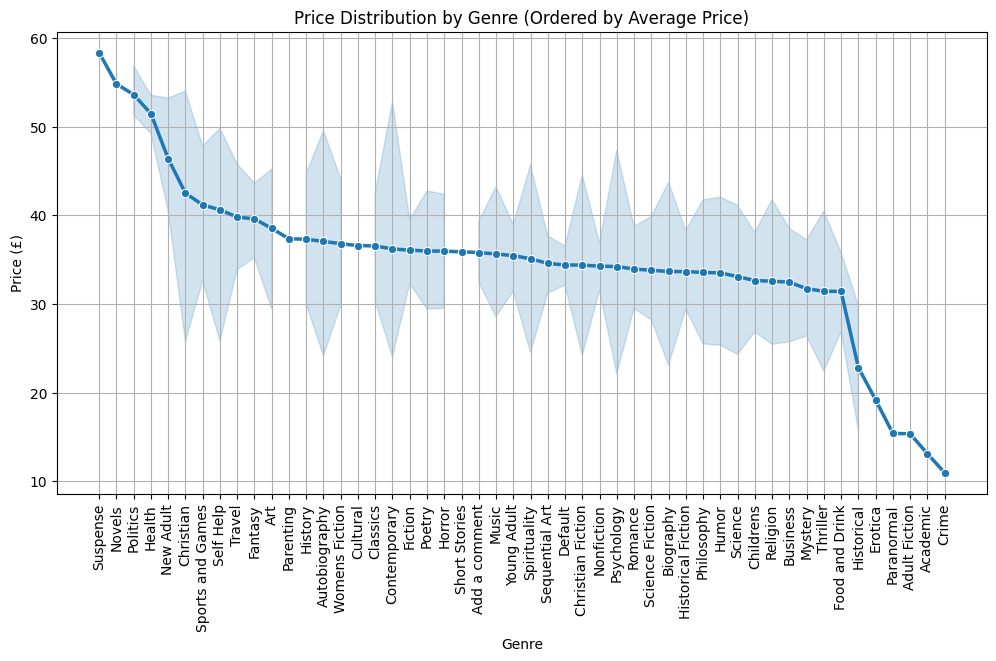

In [58]:
# Load the CSV file
csv_file = 'Web_Scraping_Project.csv'
df = pd.read_csv(csv_file)

# Remove the currency symbol (£) and convert the 'Price' column to numeric for calculation
df['Price'] = df['Price'].replace('[£]', '', regex=True).astype(float)

# Group by 'Genre' and calculate the average price for each category
average_price_by_genre = df.groupby('Genre')['Price'].mean().reset_index()

# Sort the genres by average price in descending order
average_price_by_genre = average_price_by_genre.sort_values('Price', ascending=False)

# Reorder the 'Genre' column in the original dataframe based on average price
df['Genre'] = pd.Categorical(df['Genre'], categories=average_price_by_genre['Genre'], ordered=True)

# Save the result to a new CSV file
average_price_by_genre.to_csv('Average_Price_By_Genre.csv', index=False)

# Display the results
print(average_price_by_genre)

# Plot a lineplot for prices grouped by Genre in descending order of average price
plt.figure(figsize=(12, 6))

# Create the lineplot
sns.lineplot(x='Genre', y='Price', data=df, marker='o', palette='tab10', linewidth=2.5)

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.title('Price Distribution by Genre (Ordered by Average Price)')
plt.xlabel('Genre')
plt.ylabel('Price (£)')
plt.grid(True)  # Optional: Add grid for better readability
plt.show()

### การวิเคราะห์รูปแบบความพร้อมของสินค้า ใช้ line plot

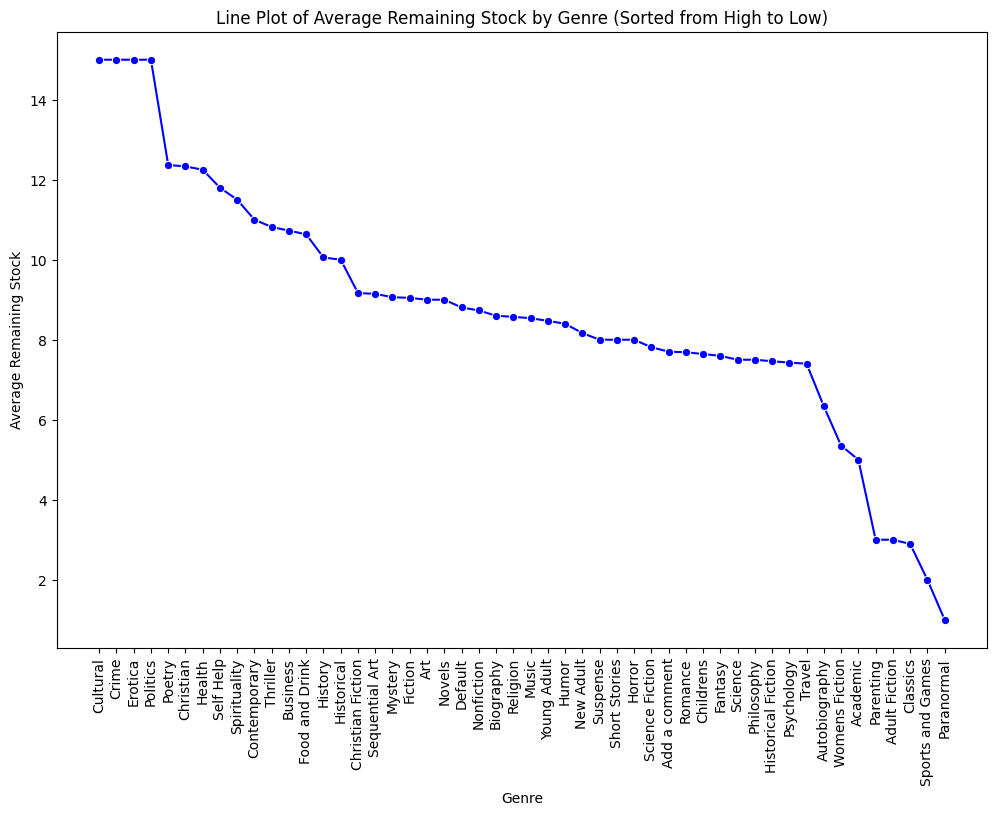

In [59]:
# Load the CSV file
csv_file = 'Web_Scraping_Project.csv'
df = pd.read_csv(csv_file)

# Clean and convert 'Price' column
df['Price'] = df['Price'].replace('[£]', '', regex=True).astype(float)

# Check and clean 'Stock Status' and 'Remaining Stock'
df['Stock Status'] = df['Stock Status'].str.strip()
df['Remaining Stock'] = pd.to_numeric(df['Remaining Stock'], errors='coerce')

# Analyze stock status by genre
genre_stock_analysis = df.groupby('Genre').agg({
    'Remaining Stock': 'mean',
    'Stock Status': lambda x: (x.str.lower() == 'out of stock').sum()
}).reset_index()

# Rename columns for clarity
genre_stock_analysis.columns = ['Genre', 'Average Remaining Stock', 'Out of Stock Count']

# Sort by 'Average Remaining Stock' in descending order (most stock first)
genre_stock_analysis = genre_stock_analysis.sort_values('Average Remaining Stock', ascending=False)

# Plot a line plot
plt.figure(figsize=(12, 8))
sns.lineplot(x='Genre', y='Average Remaining Stock', data=genre_stock_analysis, marker='o', linestyle='-', color='b')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Add titles and labels
plt.xlabel('Genre')
plt.ylabel('Average Remaining Stock')
plt.title('Line Plot of Average Remaining Stock by Genre (Sorted from High to Low)')

plt.show()

## สมาชิกในกลุ่ม

### 1. นางสาวอรวรรยา อินทร์สาลี 65109010145
### 2. นายธนากร ศรีแก้ว 65109010296
### 3. นายอภิวิชญ์ ปรีชานุวัตร 65109010308